## Pull Down Schedule from SGDQ Website

In [80]:
import requests
import json
from bs4 import BeautifulSoup

req = requests.get('https://gamesdonequick.com/schedule')
soup = BeautifulSoup(req.text)
table = soup.find('tbody')

first_rows = table.findAll('tr', attrs={'class': None})
games = list()
for row in first_rows:
    second_row = row.findNext('tr', attrs={'class': 'second-row'})
    duration = 0
    if second_row:
        duration = second_row.findNext('td').text.strip()
    runner_text = row.find('td', attrs={'rowspan': 2})
    runner = runner_text.text.strip() if runner_text else ""
    game = {
        'title': row.find('td', attrs={'class': None}).text,
        'duration': duration,
        'runner': runner
    }
    games.append(game)

## Remove Blacklisted 'Games' 
(e.g. Setup Blocks)

In [81]:
black_list = ['Pre-Show', 'Setup Block', 'Finale']

games = [x for x in games if not any(x['title'].startswith(y) for y in black_list)]

## Download Game Data
Requests user input for ambiguous responses

(Takes a long time)

In [93]:
from IPython.display import clear_output
def search_game(name):
    base_url = "http://www.giantbomb.com/api"
    api_key = "1a2b6ca5a6672075fad627af8567197ebc76740f"
    headers = {'User-agent': 'Python'}
    # Construct query URL
    url = (base_url + "/search/?api_key={0}&format=json&query=\"{1}\"/resouces='game'&limit=10".
        format(api_key, name.encode('ascii','replace')))
    response = requests.get(url, headers=headers).text
    results = json.loads(response)
    for i, res in enumerate(results['results'][:10]):
        if(res['name'] == name):
            return res
        print "{0}: {1}".format(i,res['name'].encode('ascii', 'replace'))
    print "Title: {0}".format(name.encode('ascii', 'replace'))
    correct = int(input("Correct Index: "))
    if correct < 0:
        return {}
    return results['results'][correct]

for i, game in enumerate(games):
    if 'data' in game and game['data'] is not None:
        continue
    print "\r({0}/{1}) Searching for: {2}".format(i + 1, len(games), game['title'].encode('ascii', 'ignore'))
    game['data'] = search_game(games[i]['title'])


(160/164) Searching for: Pokmon Red
0: Sintel: The Game
1: Virus: The Game
2: Game of Emperors
3: Zombie Game
4: The Simpsons Game
5: Wipeout: The Game
6: Space Game
7: BECK: The Game
8: The Game of Harmony
9: Game Party
Title: Pok?mon Red
Correct Index: -1
(161/164) Searching for: TAS Block
0: Sintel: The Game
1: Virus: The Game
2: Game of Emperors
3: Zombie Game
4: The Simpsons Game
5: Wipeout: The Game
6: Space Game
7: BECK: The Game
8: The Game of Harmony
9: Game Party
Title: TAS Block
Correct Index: -1
(162/164) Searching for: Final Fantasy VI
(163/164) Searching for: Super Metroid
(164/164) Searching for: Super Mario RPG: Legend of the Seven Stars


In [100]:
def search_id(game_id):
    base_url = "http://www.giantbomb.com/api"
    api_key = "1a2b6ca5a6672075fad627af8567197ebc76740f"
    headers = {'User-agent': 'Python'}
    # Construct query URL
    url = (base_url + "/game/{1}/?api_key={0}&format=json".
        format(api_key, game_id))
    response = requests.get(url, headers=headers).text
    try:
        results = json.loads(response)
    except Exception as e:
        print response
    return results['results']
for game in games:
    if game['data'] == {}:
        print "Title: {0}".format(game['title'].encode('ascii', 'replace'))
        game_id = raw_input("Game ID: ")
        if game_id == "x":
            continue
        game['data'] = search_id(game_id)

Title: Runny Egg
Game ID: x
Title: Sonic Colors DS
Game ID: 3030-31428
Title: Sonic the Hedgehog (2006)
Game ID: 3030-20584
Title: Final Doom: The Plutonia Experiment
Game ID: 3030-750
Title: Gimmick!
Game ID: 3030-6037
Title: Tetris: The Grand Master Series Exhibition
Game ID: 3030-42507
Title: Kirby & the Amazing Mirror
Game ID: 3030-3095
Title: Pok?mon Red
Game ID: 3030-3966
Title: TAS Block
Game ID: x


In [125]:
actual_games = [x for x in games if x['data']]
with open("games_list.txt", "w+") as f:
    for game in actual_games:
        f.write(json.dumps(game) + "\n")

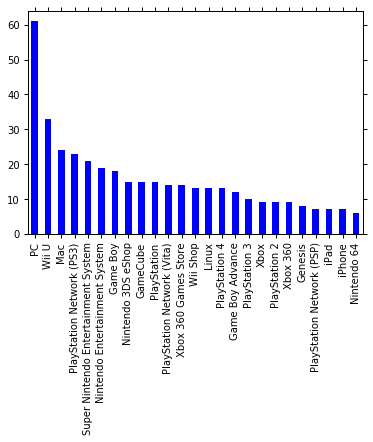

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

platforms = list()
for game in actual_games:
    if 'platforms' in game['data'] and game['data']['platforms']:
        platforms += ([x['name'] for x in game['data']['platforms']])
platforms = pd.Series(platforms)
platforms.value_counts()[:25].plot(kind='bar')
plt.savefig('platforms.png')


Earliest Release
title           Zelda II: The Adventure of Link
duration                        0 days 01:05:00
runner                           Simpol, Pro_JN
release_date                1987-01-14 00:00:00
Name: 104, dtype: object

Latest Release
title           Momodora: Reverie Under the Moonlight
duration                              0 days 00:40:00
runner                                Halfcoordinated
release_date                      2016-03-04 00:00:00
Name: 61, dtype: object

Min Duration
title                   Celeste
duration        0 days 00:05:00
runner              SecksWrecks
release_date                NaT
Name: 57, dtype: object

Max Duration
title              Final Fantasy VI
duration            0 days 04:05:00
runner              bichphuongballz
release_date    1994-04-02 00:00:00
Name: 159, dtype: object


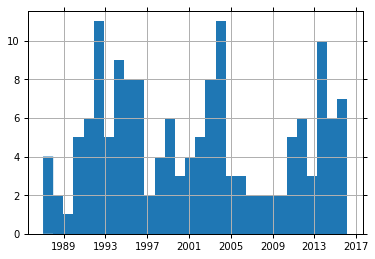

In [216]:

actual_games[0]['data']
game_frame = pd.DataFrame()

game_frame['title'] = [x['title'] for x in actual_games]
game_frame['duration'] = [str(x['duration']) for x in actual_games]
game_frame['runner'] = [x['runner'] for x in actual_games]
game_frame['release_date'] = [x['data']['original_release_date'] if 'original_release_date' 
                           in x['data'] else None for x in actual_games]
game_frame['release_date'] = pd.to_datetime(game_frame['release_date'])
game_frame['duration'] = pd.to_timedelta(game_frame['duration'])

print "\nEarliest Release"
print game_frame.ix[game_frame['release_date'].idxmin()]
print "\nLatest Release"
print game_frame.ix[game_frame['release_date'].idxmax()]

print "\nMin Duration"
print game_frame.ix[game_frame['duration'].idxmin()]
print "\nMax Duration"
print game_frame.ix[game_frame['duration'].idxmax()]


game_frame['release_date'].hist(bins=30)

Text(0,0.5,u'Avg. Game Duration (minutes)')

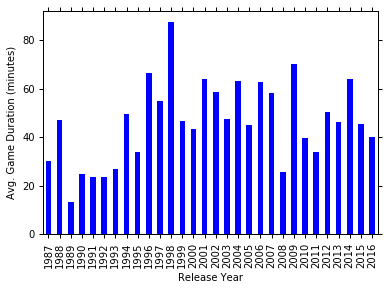

In [317]:
duration_grouped = game_frame.groupby(lambda x: game_frame.ix[x]['release_date'].year)
duration_by_year = duration_grouped.aggregate(np.sum)['duration'].astype('timedelta64[m]')
mean_duration_by_year = duration_by_year / duration_grouped.count()['duration']
ax = mean_duration_by_year.plot(kind='bar')
xtl = [item.get_text()[:4] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)
plt.xlabel("Release Year")
plt.ylabel("Avg. Game Duration (minutes)")